In [ ]:
!pip install gdown

In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_id = "1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56"
dataset = "accidents_dataset.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset, quiet=False)

original_dataset = pd.read_csv(dataset)
print(original_dataset.info())

Downloading...
From: https://drive.google.com/uc?id=1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56
To: /content/accidents_dataset.csv
100%|██████████| 4.30M/4.30M [00:00<00:00, 20.4MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

In [ ]:
#Replace 'na' with NaN
original_dataset.replace('na', np.nan, inplace=True)

#Replace all empty cells with the most common value
for col in original_dataset.columns:
    if original_dataset[col].isnull().any():
        original_dataset[col] = original_dataset[col].fillna(original_dataset[col].mode()[0])

label_encoder = LabelEncoder()

#Apply label encoding to each column
for column in original_dataset.columns:
    original_dataset[column] = label_encoder.fit_transform(original_dataset[column])

print(original_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Time                         12316 non-null  int64
 1   Day_of_week                  12316 non-null  int64
 2   Age_band_of_driver           12316 non-null  int64
 3   Sex_of_driver                12316 non-null  int64
 4   Educational_level            12316 non-null  int64
 5   Vehicle_driver_relation      12316 non-null  int64
 6   Driving_experience           12316 non-null  int64
 7   Type_of_vehicle              12316 non-null  int64
 8   Owner_of_vehicle             12316 non-null  int64
 9   Service_year_of_vehicle      12316 non-null  int64
 10  Defect_of_vehicle            12316 non-null  int64
 11  Area_accident_occured        12316 non-null  int64
 12  Lanes_or_Medians             12316 non-null  int64
 13  Road_allignment              12316 non-null  i

In [ ]:
#Assign training and testing columns
target_col = 'Accident_severity'
y = original_dataset[target_col]
x = original_dataset.drop(columns=[target_col])

#Assign training and testing data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=46)


In [ ]:
model = XGBClassifier(n_estimators=1000, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, objective='multi:softprob', eval_metric='mlogloss')

model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

###F1 Accuracy Heat Map

The model’s 85% accuracy is driven almost entirely by correctly predicting the majority class (Severity Level: Slight) while missing most of the rare Class 0 (Fatal) and 1 (Severe) cases. This imbalance means that the overall accuracy seems high but the model yields very low recall on the less frequent classes. To fix this, we could apply imbalance‑handling methods like class weighting or resampling and tune the per-class probability thresholds using ROC/precision–recall analysis. We could also start using metrics like macro‑F1 to ensure improvements are balanced across all classes.

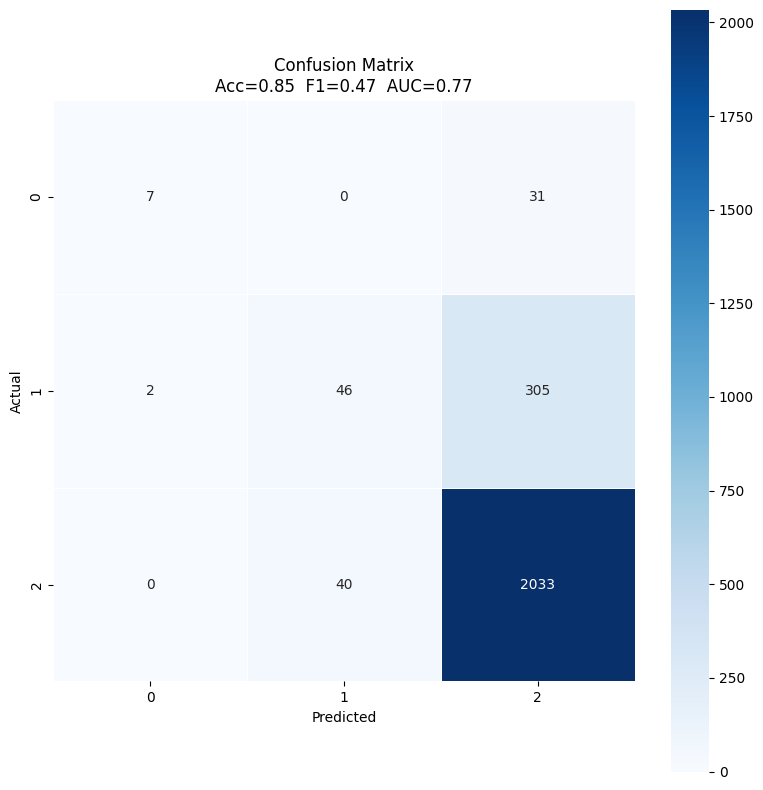

In [ ]:
# Accuracy Heat Map Visualization
from sklearn.metrics import confusion_matrix

# compute
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)
cm = confusion_matrix(y_test, y_pred)   # raw counts

# plot
plt.figure(figsize=(8,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",                   # integer counts
    cmap="Blues",
    xticklabels=model.classes_,
    yticklabels=model.classes_,
    square=True,
    linewidths=0.5
)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title(
    f"Confusion Matrix\n"
    f"Acc={accuracy_score(y_test,y_pred):.2f}  "
    f"F1={f1_score(y_test,y_pred,average='macro'):.2f}  "
    f"AUC={roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro'):.2f}"
)
plt.tight_layout()
plt.show()


###Feature Importance

This bar plot ranks each feature by the total gain it contributes when used in model splits, which is useful for seeing which variables, like weather, road type, or time of day, are the biggest factors in the predictions. By highlighting only the top features, it helps us figure out which features to select and which areas are safe to drop/reduce. To be succinct, it helps us visualize what the model is paying attention to, which is important for informing our training.

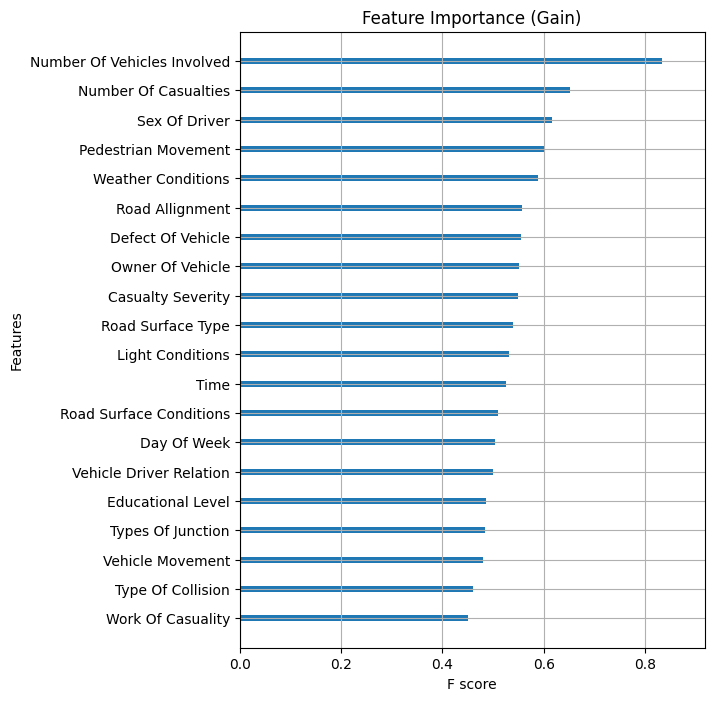

In [ ]:
# Feature Importance Bar Plot

from xgboost import plot_importance

# plot top 20 features by gain
fig, ax = plt.subplots(figsize=(6, 8))
plot_importance(model,
                importance_type='gain',
                max_num_features=20,
                show_values=False,
                ax=ax)

# grab the original tick texts, reformat, and set them back
new_labels = [
    lbl.get_text().replace('_', ' ').title()
    for lbl in ax.get_yticklabels()
]
ax.set_yticklabels(new_labels)

ax.set_title("Feature Importance (Gain)")
plt.show()

###One Vs Rest ROC Curves

We plot a separate ROC curve for each severity class by treating it as “positive” vs. all the others to reveal how well the model discriminates between each category across all possible thresholds. The AUC values give an idea of overall class separation strength, whereas the shapes of the curves allow us to visualize how we are balancing the capture of more true positives and avoiding any false alarms. This helps us understand performance per class when we are operating in an imbalanced, multiclass setting like the traffic accident data, guiding us to choose the most optimal probability cutoffs.

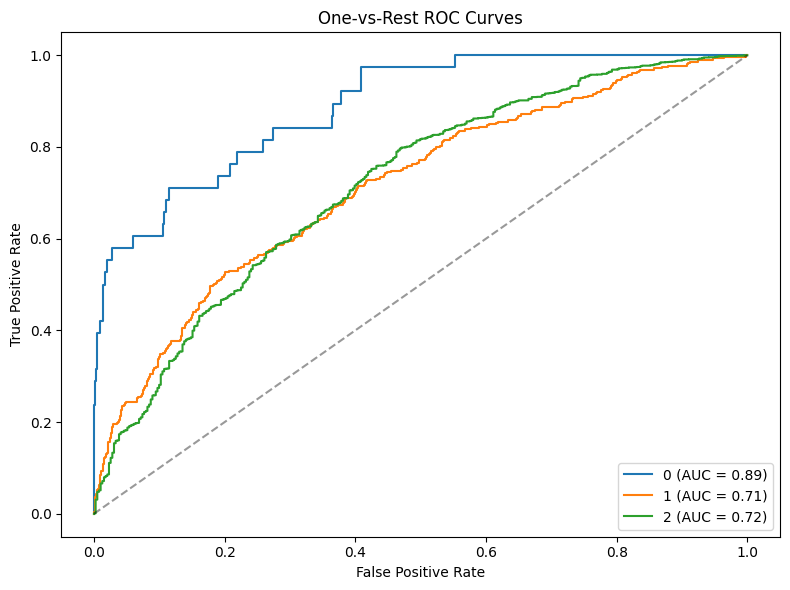

In [ ]:
# OVA ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output
y_bin = label_binarize(y_test, classes=model.classes_)
y_proba = model.predict_proba(x_test)

plt.figure(figsize=(8,6))
for i, cls in enumerate(model.classes_):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0,1],[0,1],"k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One‑vs‑Rest ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

###Calibration Curve

Using a calibration plot allows us to compare the model’s predicted probabilities for a given class against the actual observed frequency of that class. We can observe how the curve appears in correspondance to the diagonal line to determine how well calibrated our current probabilities are - if the curve hugs the line, the probabilities are well‑calibrated, meaning they are good support for trustworthy risk estimates. This informs us that our model's confidence scores match reality, not just the predictions.

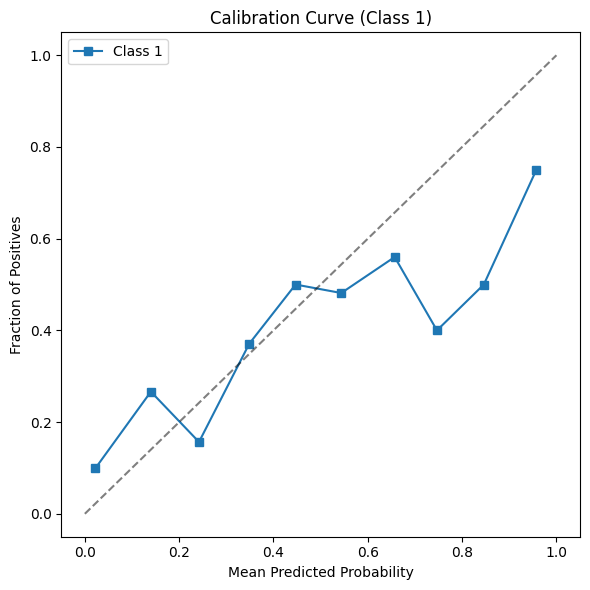

In [ ]:
# Reliability Diagram (Calibration)

from sklearn.calibration import calibration_curve

# For a single class (e.g., severity = 1)
probs = y_proba[:, model.classes_.tolist().index(1)]
true = (y_test == 1).astype(int)

prob_true, prob_pred = calibration_curve(true, probs, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, "s-", label="Class 1")
plt.plot([0,1],[0,1],"k--", alpha=0.5)
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Class 1)")
plt.legend()
plt.tight_layout()
plt.show()